In [1]:
import hyperspy.api as hs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cmasher as cmr
import os
import numba
import cv2
from IPython.display import Video
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle, Circle
from matplotlib.patches import Polygon
from matplotlib.path import Path

In [4]:
# Define file path
base_path = "E:/1_DATA_BNL_2025/250518_FAPbI3_Beam_damage/Sample_2_IDK/Main_exp_not-saturated-pixels/ROI3-1-RT/Hour_00/"
file_path = base_path+"Minute_00/Second_01/17_Hour_00_Minute_00_Second_01_Frame_0000.dm4"
image_dm = hs.load(file_path)
image = image_dm.data

In [5]:
# Constants
dose_rate = 3.82 # e/A²s
frames_per_second = 0.5  # Frames per second
dose_per_frame = dose_rate / frames_per_second  # Dose per frame

In [6]:

image_list = []

# Find the total number of Minute directories
minute_dirs = [d for d in sorted(os.listdir(base_path)) if d.startswith("Minute_")]
end_of_min = len(minute_dirs)

# Iterate over the Minute directories (Minute_00, Minute_01, ...)
for min_idx, min_dir_name in enumerate(minute_dirs):
    min_dir = os.path.join(base_path, min_dir_name)
    
    # Find the total number of Second directories in the current Minute directory
    second_dirs = [d for d in sorted(os.listdir(min_dir)) if d.startswith("Second_")]
    end_of_sec = len(second_dirs)
    
    # Iterate over the Second directories (Second_00, Second_01, ...)
    for sec_idx, second_dir_name in enumerate(second_dirs):
        second_dir = os.path.join(min_dir, second_dir_name)
        
        # Get all the .dm4 files in the directory
        dm4_files = [f for f in sorted(os.listdir(second_dir)) if f.endswith(".dm4")]
        
        # Iterate through each .dm4 file
        for file_name in dm4_files:
            file_path = os.path.join(second_dir, file_name)
            
            # Load the .dm4 file using hyperspy
            image_dm = hs.load(file_path)  # Use hs.load() from hyperspy.api
            image_data = image_dm.data

            # Keep the original pixel values (no normalization)
            image_data_3d = cv2.cvtColor(image_data.astype(np.uint8), cv2.COLOR_GRAY2BGR)
            
            # Append the image data to the stack
            image_list.append(image_data_3d)

print(f"Processed {len(image_list)} images from {end_of_min} Minute directories and their Second subdirectories.")


Processed 97 images from 4 Minute directories and their Second subdirectories.


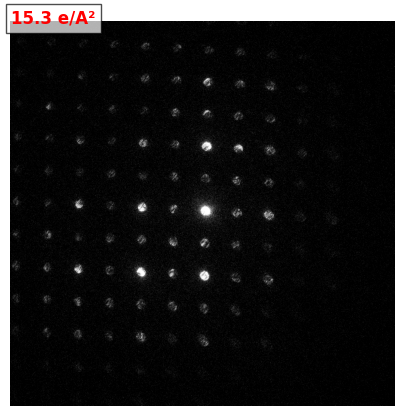

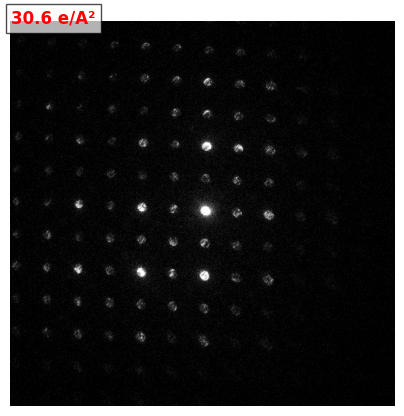

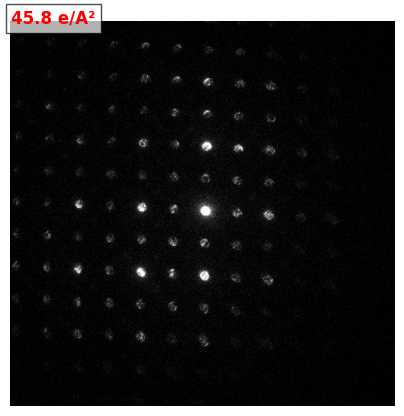

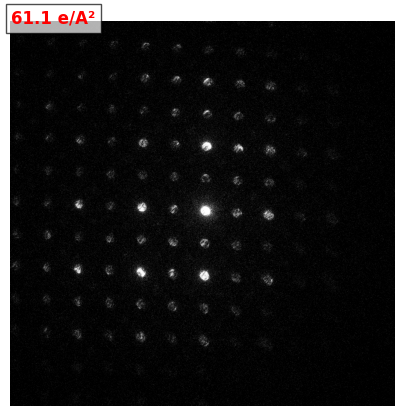

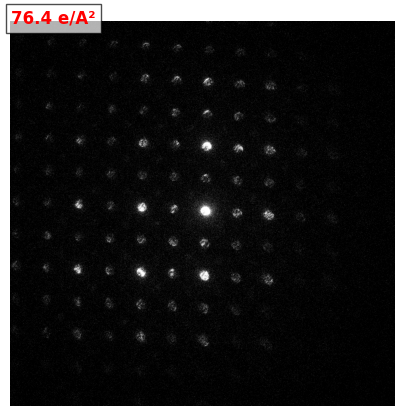

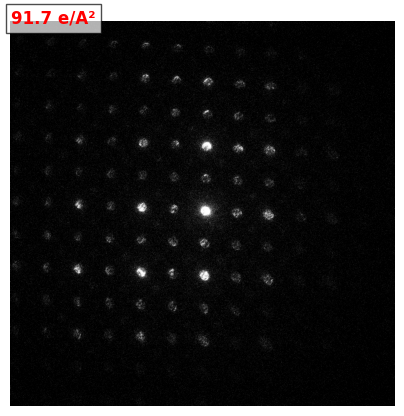

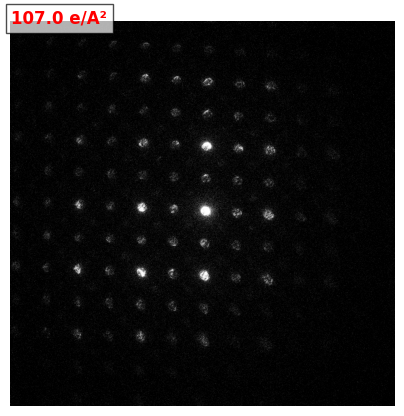

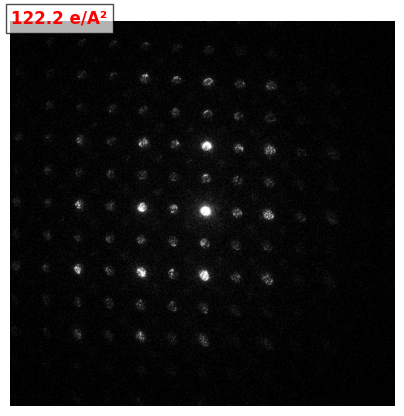

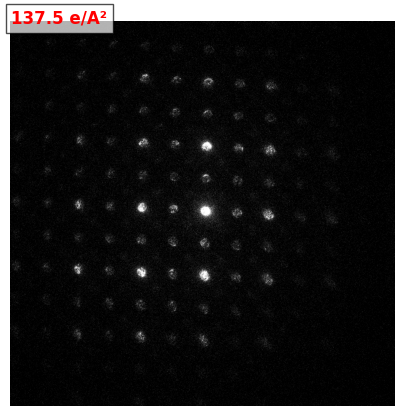

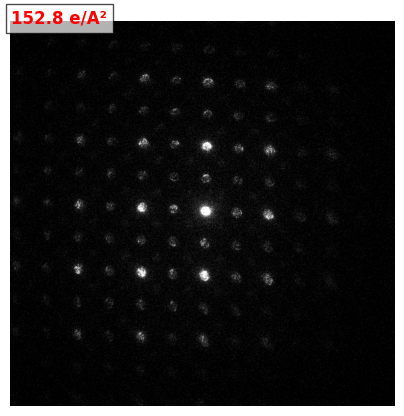

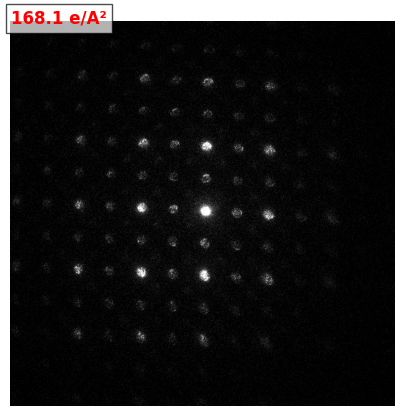

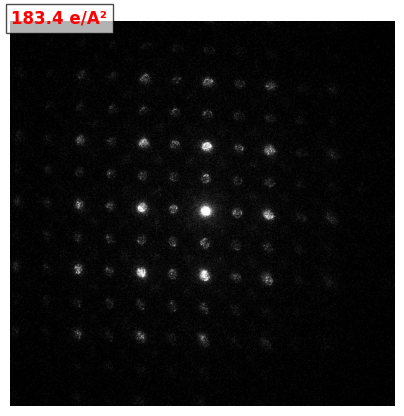

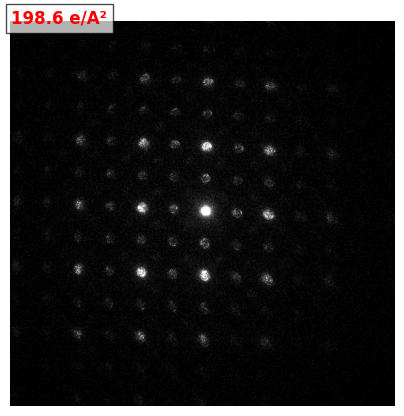

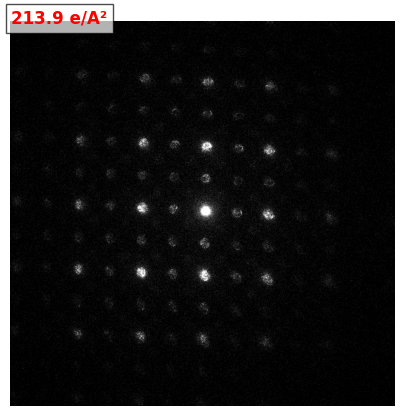

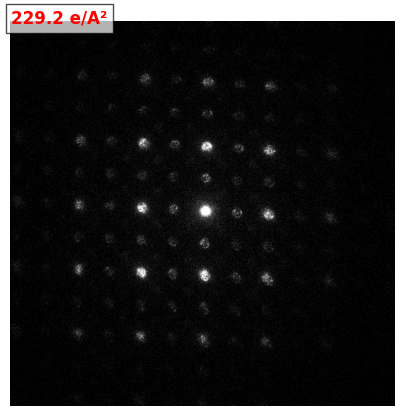

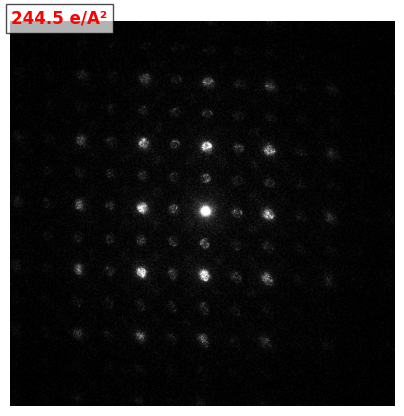

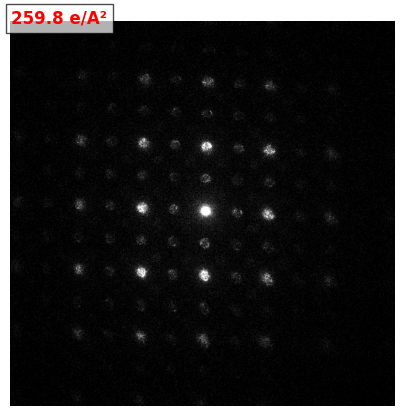

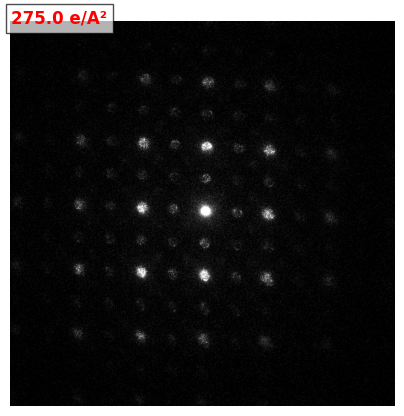

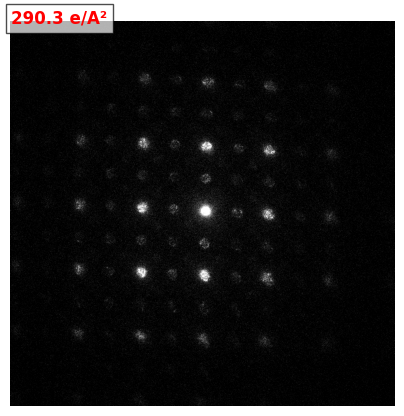

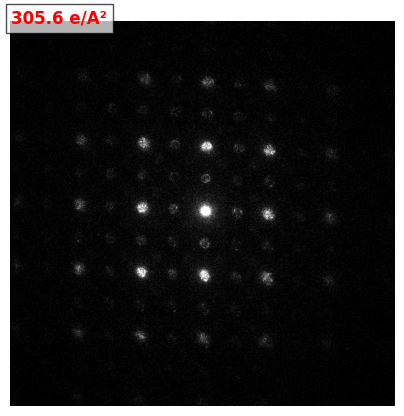

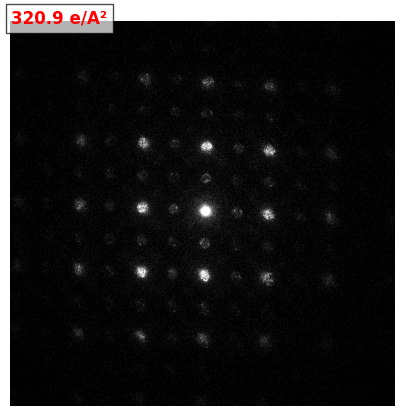

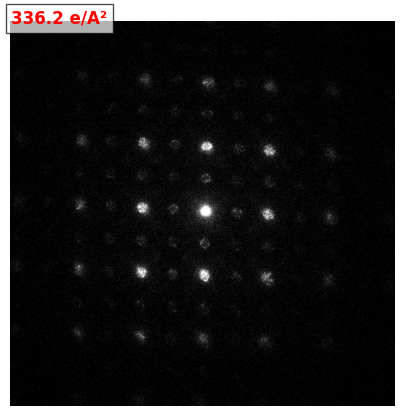

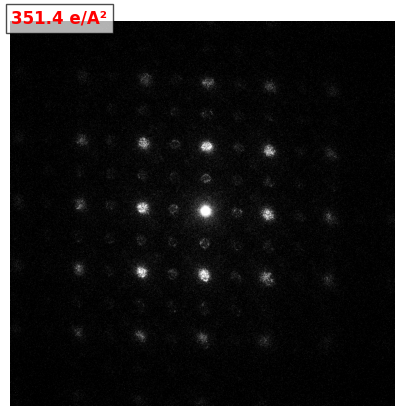

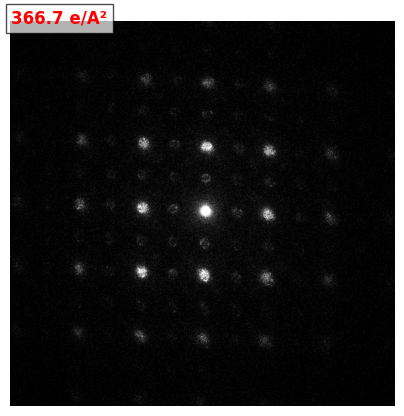

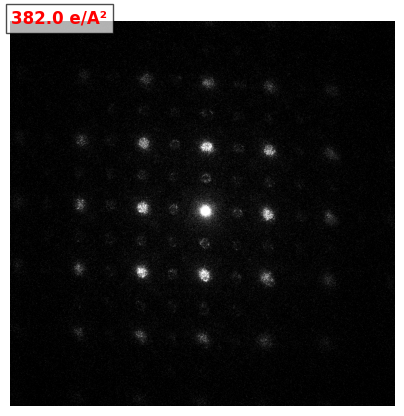

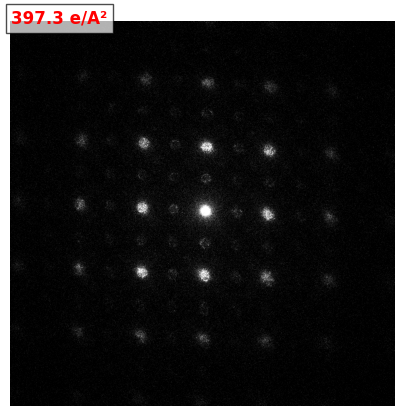

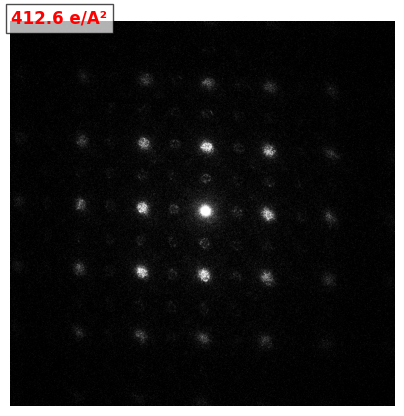

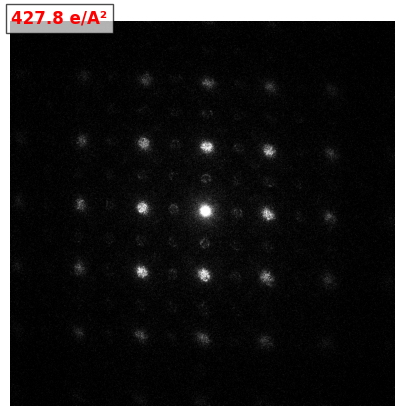

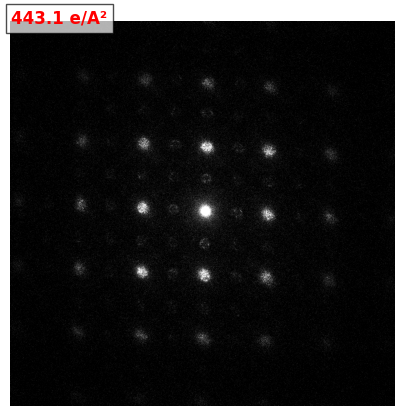

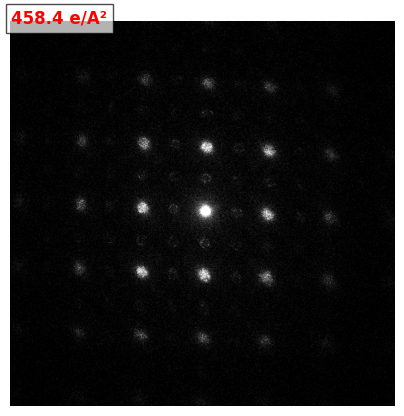

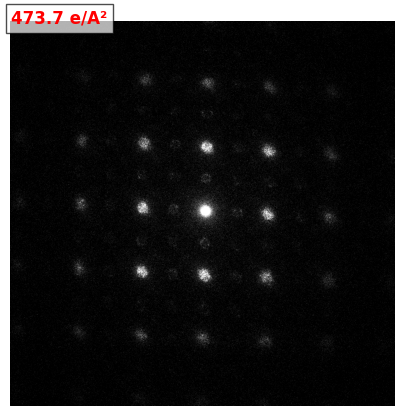

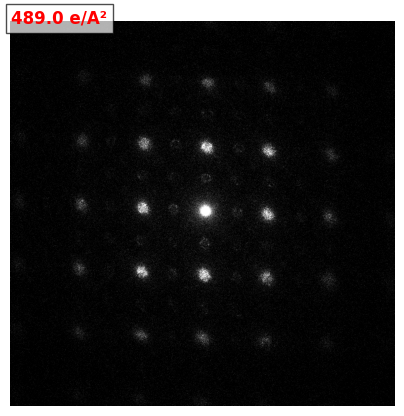

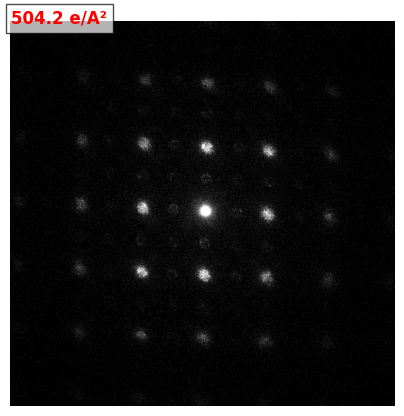

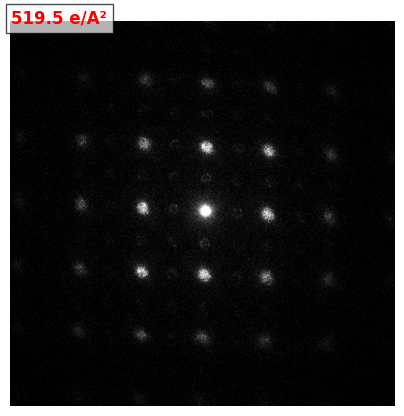

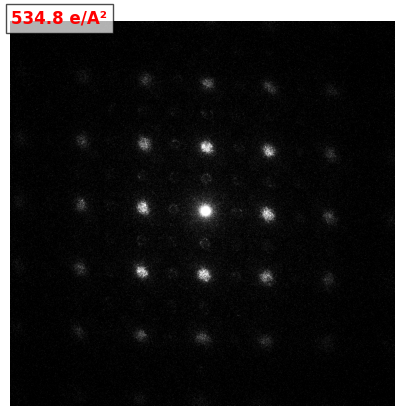

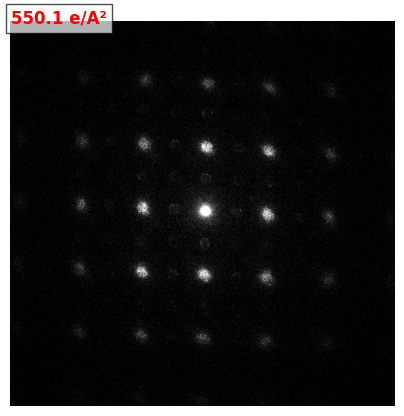

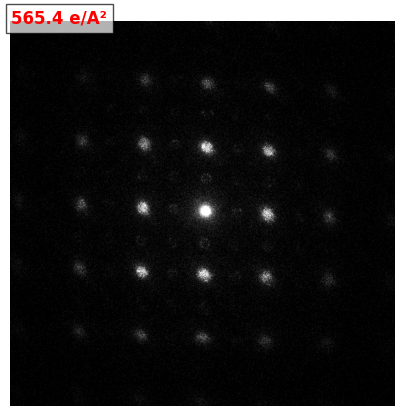

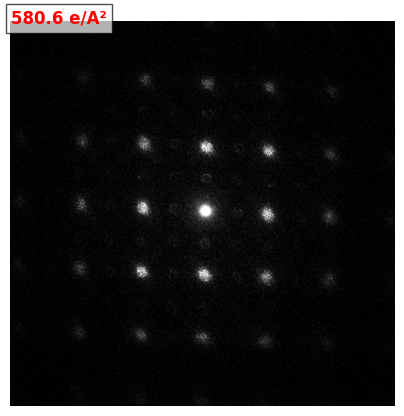

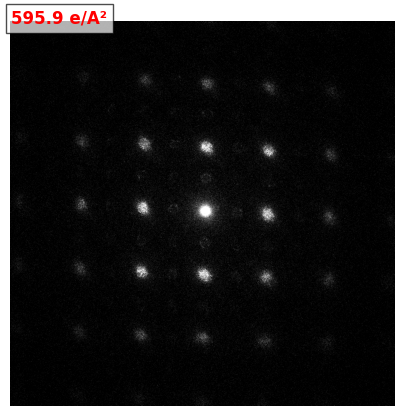

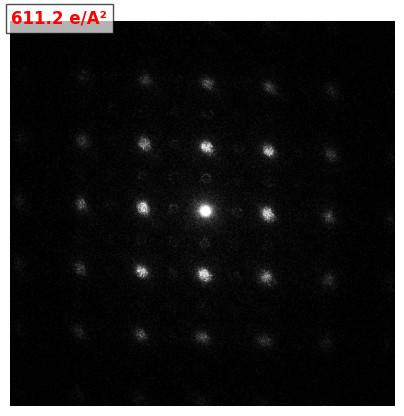

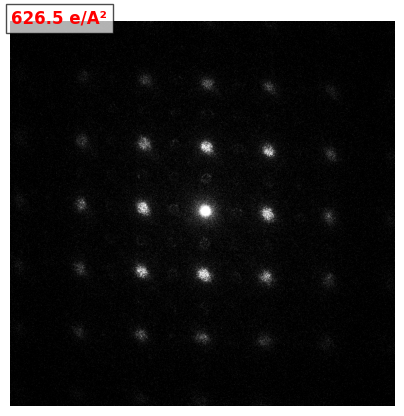

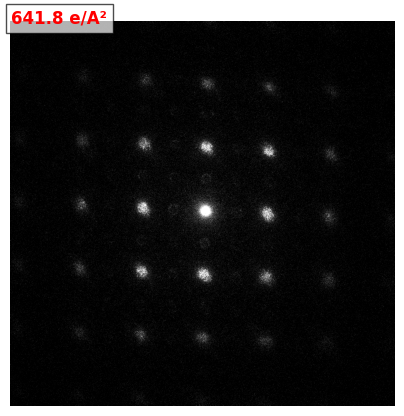

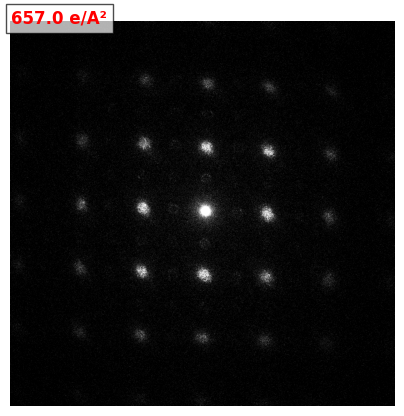

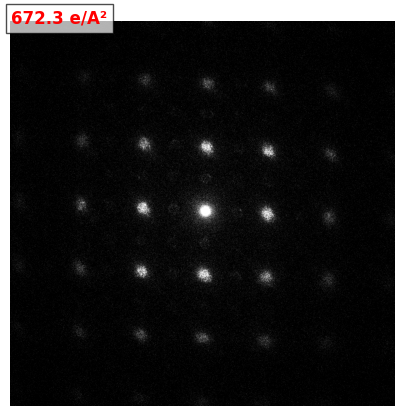

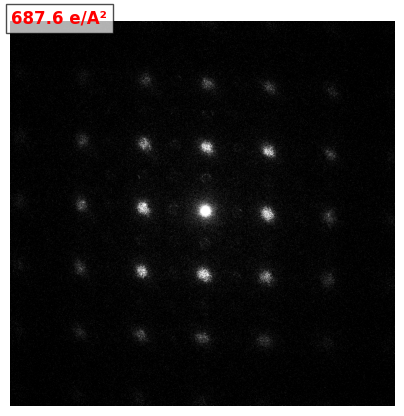

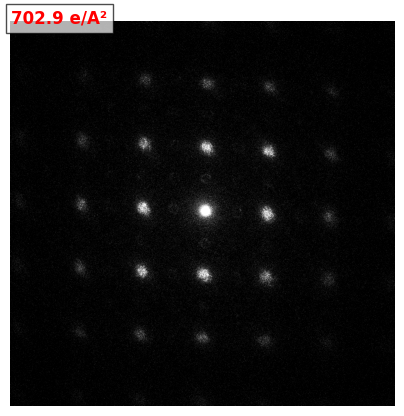

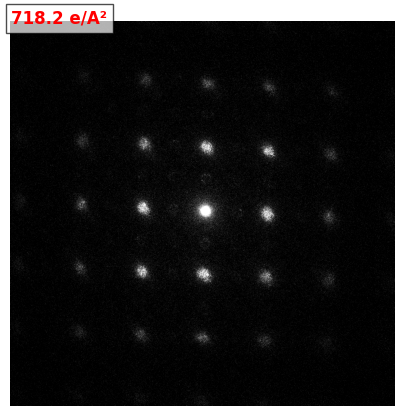

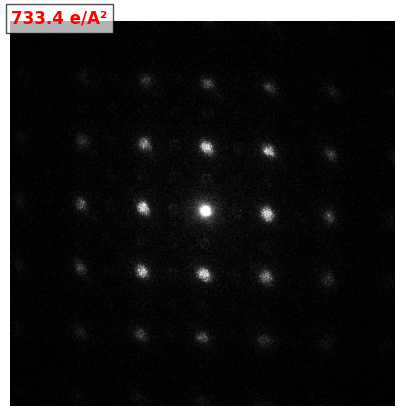

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 원본 이미지 리스트에서 첫 5장을 제외
filtered_images = image_list[1:]


target_dose = 20  # 목표 총 선량
frames_per_set = int(target_dose / dose_per_frame)  # 한 세트당 프레임 수
num_sets = len(filtered_images) // frames_per_set  # 총 세트 개수

# 각 그룹별 summation (벡터 연산 활용하여 속도 개선)
summed_images = np.array([
    np.sum(filtered_images[i * frames_per_set:(i + 1) * frames_per_set], axis=0)
    for i in range(num_sets)
])

# 마지막 차원이 있는 경우 제거 (3D -> 2D 변환)
if summed_images.ndim == 4:
    summed_images = np.mean(summed_images, axis=-1)

# 감마 보정 적용
gamma = 0.01  # 감마 값 조절 가능
summed_images = summed_images ** gamma

# 전자 선량 계산
dose_values = np.array([dose_per_frame * frames_per_set * (i + 1) for i in range(num_sets)])

# 개별 이미지 플롯
total_images = len(summed_images)
for i in range(total_images):
    plt.figure(figsize=(5, 5))
    plt.imshow(summed_images[i], cmap='gray')
    plt.axis("off")
    
    # 총 전자 선량 표시
    dose_text = f"{dose_values[i]:.1f} e/A²"
    plt.text(10, 20, dose_text, color='red', fontsize=12, weight='bold', bbox=dict(facecolor='white', alpha=0.7))
    
    plt.show()